# Analysis of data from the Covid-19 pandemic

In [1]:
%reset -f
%matplotlib inline

In [2]:
from datetime import datetime, timedelta
from copy import deepcopy
from collections import namedtuple
from pathlib import Path

import numpy as np
import pandas as pd
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 
from scipy.integrate import odeint
import scipy.optimize as op
import statsmodels.api as sm
import statsmodels.formula.api as smf

import util as ut

In [3]:
plt.rcParams['figure.figsize'] = ut.PD_FIG_SIZE_LARGE
pd.options.display.max_rows = 8

sns.set()
FIG_COLOR_PALETTE = sns.color_palette()

# https://de.wikipedia.org/wiki/Deutschland
GERMANY_INHABITANTS = 83e6
GERMANY_INTENSIVE_CARE_PLACES = 23e3
GERMANY_LOCKDOWN_DATE = datetime(2020, 3, 16)
GERMANY_LOCKDOWN_WEAKEN_1 = datetime(2020, 4, 20)

In [4]:
%%html
<!-- left align markdown tables -->
<style>table {float:left;}</style>

## Loading the Covid-19 cases data

Load the `cases.csv`, which was generated by `retriev_clean_data.ipynb`.

In [5]:
filename_cases = Path('cases.csv')
assert filename_cases.exists()

df = pd.read_csv(filename_cases, index_col=[0], parse_dates=[0], skipinitialspace=True)
assert df.index.dtype == np.dtype('M8[ns]')

df.tail(3)

,Germany_JHU,Austria_JHU,France_JHU,Germany_infectious_BMP,Germany_recovered_BMP,TS_infectious_LR,TS_recovered_LR
date,,,,,,,
2020-06-11,186691,17034,192493,6956.0,179733.0,-14.0,1206.0
2020-06-12,187226,17064,193220,6906.0,180318.0,-14.0,1206.0
2020-06-13,187267,17078,193746,6502.0,180763.0,-14.0,1206.0


In [6]:
# initialize df dependent constants
GERMANY_LOCKDOWN_INDEX = np.where(df.index == GERMANY_LOCKDOWN_DATE)[0][0]
GERMANY_LOCKDOWN_INDEX

54

### Plotting Covid-19 cases data

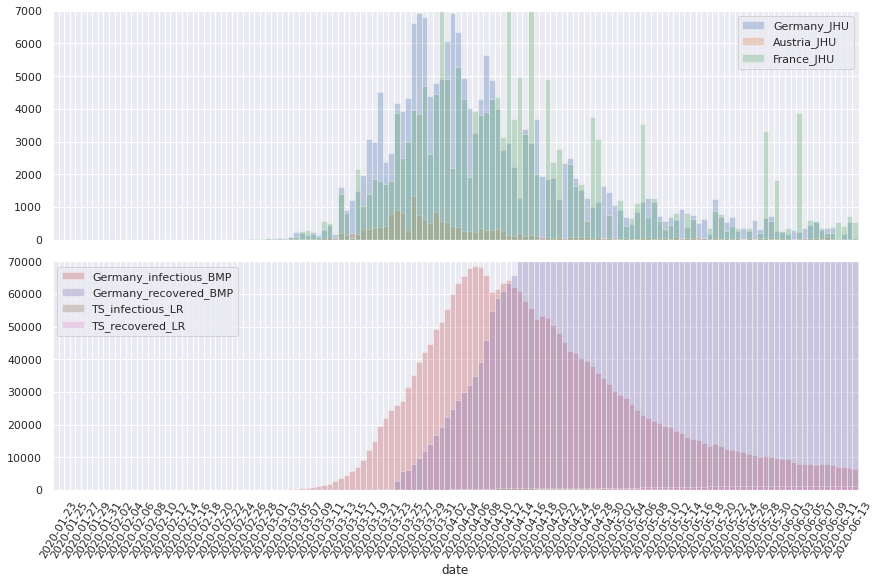

In [7]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False,
                       figsize=ut.MPL_FIG_SIZE_LARGE, constrained_layout=True)

for i, key in enumerate(df.keys()):
    _kwargs = dict(alpha=0.3, align='edge', color=FIG_COLOR_PALETTE[i], width=1, stacked=False)
    if 'JHU' in key:
        df[[key]].diff().plot.bar(ax=ax[0], **_kwargs)
    else:
        df[[key]].plot.bar(ax=ax[1], **_kwargs)
ax[0].set_ylim(0, 7e3)
ax[1].set_ylim(0, 7e4)
labels = (l.get_text()[:10] if i % 2 else "" for i, l in enumerate(ax[1].get_xticklabels()))
ax[1].set_xticklabels(labels, rotation=60);

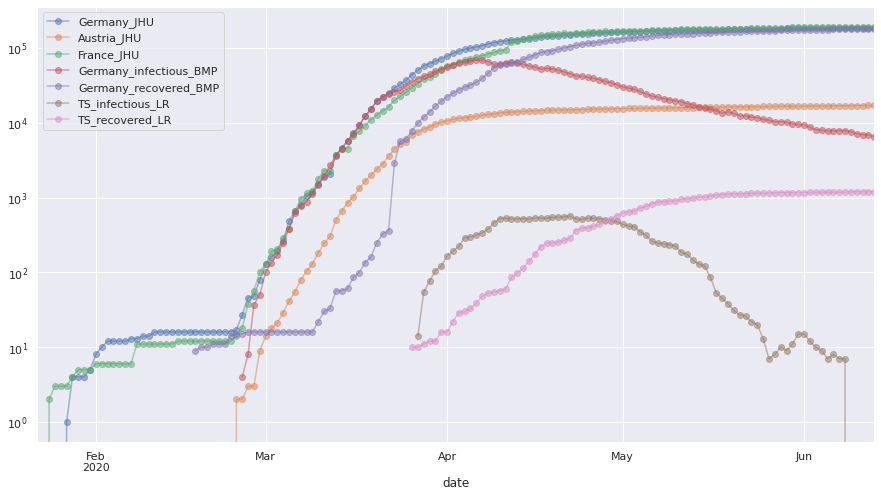

In [8]:
ax = df.plot(style='o-', figsize=ut.PD_FIG_SIZE_LARGE, logy=True, alpha=0.5)

## Fit $2^x$ to the JHU data of Germany

### Scratchpad for getting intuition on exponentail functions

In [9]:
x = np.arange(4)
np.exp(x), 2.718*2.718*2.718

(array([ 1.        ,  2.71828183,  7.3890561 , 20.08553692]),
 20.079290231999998)

In [10]:
np.exp(1)**(x), np.exp(x)

(array([ 1.        ,  2.71828183,  7.3890561 , 20.08553692]),
 array([ 1.        ,  2.71828183,  7.3890561 , 20.08553692]))

In [11]:
np.log(2**6)/np.log(2), 2**6

(6.0, 64)

### Fit $2^\frac{\text{days}}{\text{rate}}$ for certain time spans

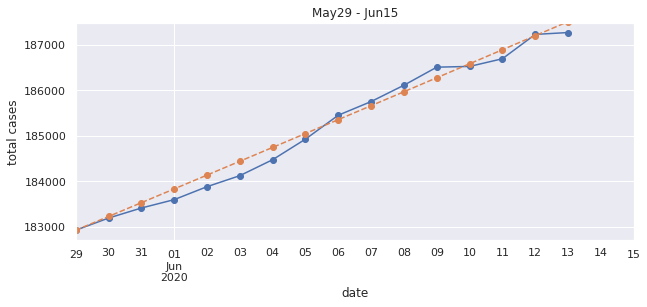

In [12]:
EXP_FIT_COUNTRY_KEY = "Germany_JHU"
_kwargs = dict(df=df, begin_date=datetime(2020, 5, 29), key=EXP_FIT_COUNTRY_KEY)
_end_date = datetime.now() + timedelta(days=1)
_rate = 420

_x0 = ut.calc_pow2_zero(rate=_rate, **_kwargs)
expfct = lambda day_range: 2**((day_range + _x0)/_rate)
ax = ut.plot_pow2_fit(end_date=_end_date, expfct=expfct, **_kwargs)

EXP_RATE = _rate

### $2^\frac{\text{days}}{\text{rate}}$ manually fitted
Time spans where identified by looking at the log plot above

[//]: # (
the complete table, only a subset is rendered below

| begin date |  end date  | rate |
| ---------- | ---------- | -----:|
| 2020-02-25 | 2020-03-11 |   2.2 |
| 2020-03-13 | 2020-03-19 |   2.9 |
| 2020-03-21 | 2020-03-28 |   5.1 |
| 2020-03-28 | 2020-04-03 |   9.1 |
| 2020-04-03 | 2020-04-04 |  13.2 |
| 2020-04-03 | 2020-04-09 |  16.1 |
| 2020-04-10 | 2020-04-19 |  35.5 |
| 2020-04-20 | 2020-04-26 |  57.0 |
| 2020-04-27 | 2020-05-03 |  88.0 |
| 2020-05-08 | 2020-05-22 | 185 |
)


| begin date |  end date  | rate |
| ---------- | ---------- | -----:|
| 2020-02-25 | 2020-03-11 |   2.2 |
| 2020-03-13 | 2020-03-19 |   2.9 |
| 2020-03-28 | 2020-04-03 |   9.1 |
| 2020-04-10 | 2020-04-19 |  35.5 |
| 2020-04-20 | 2020-04-26 |  57.0 |
| 2020-05-05 | 2020-05-08 |  87.0 |
| 2020-05-08 | 2020-05-22 | 185 |

In [13]:
params = [_kwargs['begin_date'], _end_date, _rate]     
print(ut.markdown_table_fmt(params))

| 2020-05-29 | 2020-06-15 | 420 |


### Estimate intensive care places based on extrapolated expenential function with last `rate`

The idea of this plot is to relate a pure exponentail growth with the number of intensive care places ($\text{icp} \approx 23e3$ for Germany). Assuming 1% of the infectious people need intensive care and that people are 10 days in intensive care, results in the threshold $\frac{icp}{0.01 \cdot 10} = 230e3$.

('exp basis, for z**(day_range + _x0), z =', 1.0016517130076492)

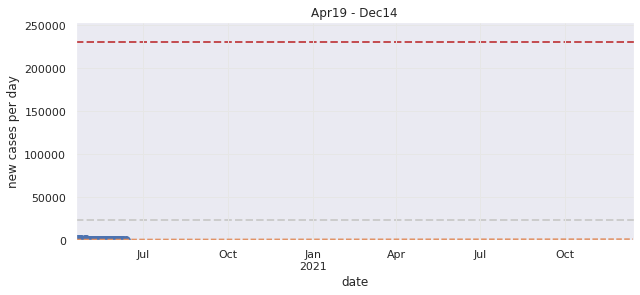

In [14]:
_kwargs = dict(begin_date=datetime(2020, 4, 19), key=EXP_FIT_COUNTRY_KEY)
_end_date = datetime.now() + timedelta(days=365 * 1.5)
_ndays = (_end_date - _kwargs['begin_date']).days

_begin_date = datetime(2020, 4, 10)

_x0 = ut.calc_pow2_zero(df, rate=_rate, **_kwargs)
diffexpfct = lambda day_range: np.diff(2**((np.concatenate([[0], day_range]) + _x0)/EXP_RATE))
ax = ut.plot_pow2_fit(df=df.diff(), end_date=_end_date, expfct=diffexpfct,
                      ndays=_ndays, figsize=ut.PD_FIG_SIZE_SMALL, linestyle='--',
                      **_kwargs)
ax.set_ylabel('new cases per day')

_kwargs2 = dict(linestyle='--', linewidth=2, zorder=0)
ax.axhline(GERMANY_INTENSIVE_CARE_PLACES, color='0.8', **_kwargs2)
ax.grid(color='0.9')
ax.axhline(GERMANY_INTENSIVE_CARE_PLACES * 10, color='r', **_kwargs2)
ax.set_ylim(0, GERMANY_INTENSIVE_CARE_PLACES * 10 * 1.1)

'exp basis, for z**(day_range + _x0), z =', 2**(1/EXP_RATE)

### Calculating $R(t)$ from the exponentail infectious cases

Note, that here
* we use the `EXP_INFECTIOUS_RATE` not the growth rate
* approximate at the current date and not at the beginning of the disease
however, both items are mandatory based on https://www.sciencedirect.com/science/article/pii/S2468042719300491. Thus the **results shall be taken with a grain of salt**.

Equations:
$$\lambda = \beta - \gamma$$
$$\beta = \lambda + \gamma$$
$$R_0 = \beta / \gamma = \frac{\lambda + \gamma}{\gamma} = \lambda / \gamma + 1$$

$$\text{with}$$
$$e^\lambda = 2^{1/\text{rate}}$$
$$\lambda = \frac{1}{\text{rate}} \log(2) / \log(e) = \frac{\log(2)}{\text{rate}}  $$

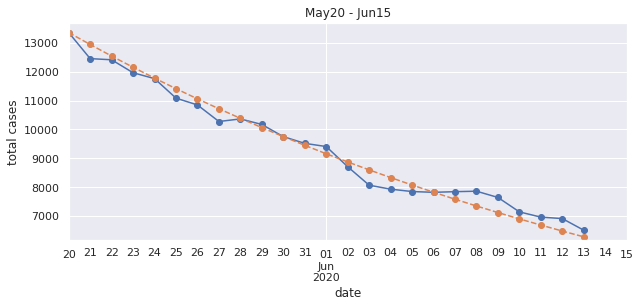

In [15]:
_kwargs = dict(df=df, begin_date=datetime(2020, 5, 20), key="Germany_infectious_BMP")
_end_date = datetime.now() + timedelta(days=1)
_rate = -22

_x0 = ut.calc_pow2_zero(rate=_rate, **_kwargs)
expfct = lambda day_range: 2**((day_range + _x0)/_rate)
ax = ut.plot_pow2_fit(end_date=_end_date, expfct=expfct, **_kwargs)

EXP_INFECTIOUS_RATE = _rate

In [16]:
EXP_INFECTIOUS_DAYS = timedelta(days=7)
EXP_GAMMA = 1 / EXP_INFECTIOUS_DAYS.days
exp_R_0 = (np.log(2)/EXP_INFECTIOUS_RATE) + 1
f'{exp_R_0=}'

'exp_R_0=0.968493309974548'

## Fit sigmoid function to the JHU data of Germany

The simoid function is the deriveate of the logistic function.

#### Logistic function primer

Based on https://mlnoga.github.io/covid19-analysis there are three differing states in the evolution of Covid-19 pandemic for each country, represented by the
* exponential function, the
* logistic function and the 
* logistic function with a long tail.

Here we look into the logistic function, as defined in https://de.wikipedia.org/wiki/Logistische_Funktion as follows:

    Die logistische Funktion, wie sie sich aus der diskreten logistischen Gleichung ergibt, beschreibt den Zusammenhang zwischen der verstreichenden Zeit und einem Wachstum, beispielsweise einer idealen Bakterien­population. Hierzu wird das Modell des exponentiellen Wachstums modifiziert durch eine sich mit dem Wachstum verbrauchende Ressource – die Idee dahinter ist also etwa ein Bakteriennährboden begrenzter Größe. Zur Anfangszeit ist der Funktionswert nicht 0, sondern es gilt f(0)>0.

$f(t) = G \frac{1}{1 + e^{-kGt + c}} $

$f'(t) = k f(t) (G - f(t))$

We introduc $b = k G$ for numerical stability, as G is large ($G \approx 1.4e5$) and k is small ($k \approx 1e-6$).

#### TODO:
- [ ] plot covariance
- [ ] describe variables of equations above
- [ ] move to logit with tail

In [17]:
%reset_selective -f ([xy][dip][A-z]+[0-9]*)
#%whos

In [18]:
LOGIT_FIT_COUNTRY_KEY = 'Germany_JHU'
LOGIT_FIT_START_DATE = datetime(2020, 3, 2)   # repr idx 40

mask = df.index >= LOGIT_FIT_START_DATE
yintegrated = df.loc[mask, LOGIT_FIT_COUNTRY_KEY].values.astype('f8')

LogitFitParams = namedtuple('LogitFitParams', 'G b c'.split())

def func(t, G, b, c):
    return G / (1.0 + np.exp(-b * t + c))

def func_derivative(t, G, b, c):
    _f = func(t, G, b, c)
    return b * _f * (1 - _f / G)

# we fit the number of new infections, which is the derivative
# of the confirmed total cases
ydata = np.diff(yintegrated)
xdata = np.arange(1, len(ydata) + 1, dtype='f8')

p0 = LogitFitParams(G=ydata.max(), b=0.1 , c=10)
_popt, pcov = op.curve_fit(func_derivative, xdata, ydata, p0)
popt = LogitFitParams(*_popt)
popt, pcov

(LogitFitParams(G=172459.52096034115, b=0.12902747238424078, c=3.9409879879531613),
 array([[ 4.60377990e+07, -2.69338997e+01, -8.28333454e+02],
        [-2.69338997e+01,  3.99296762e-05,  1.22658273e-03],
        [-8.28333454e+02,  1.22658273e-03,  4.23853322e-02]]))

-3 ('0.30', 169.0) -2 ('0.65', 535.0) -1 ('1.00', 41.0) 

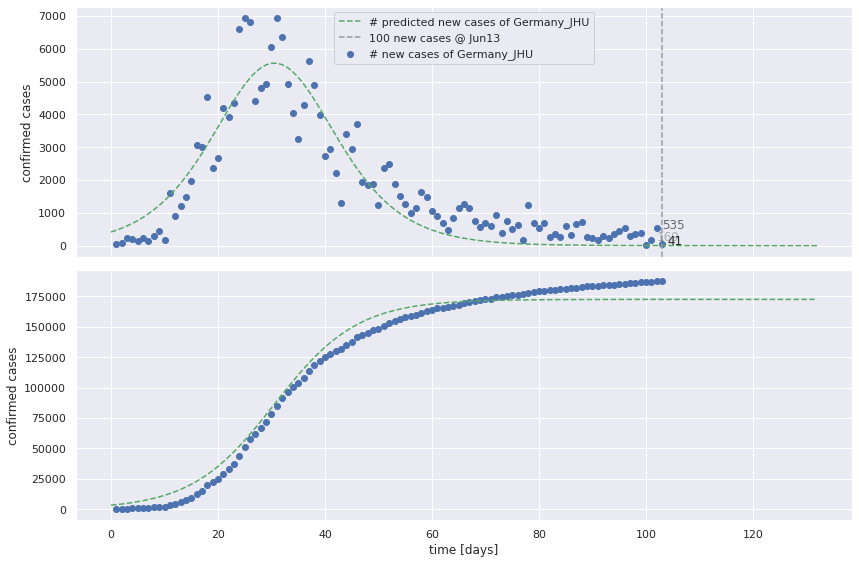

In [19]:
logit_days_to_predict = 30
xpredict = np.arange(len(xdata) + logit_days_to_predict)
ypredict = func_derivative(xpredict, *popt)

fig, ax = plt.subplots(2, 1, sharex=True, figsize=ut.MPL_FIG_SIZE_LARGE)
ax[0].scatter(xdata, ydata, label='# new cases of %s' % LOGIT_FIT_COUNTRY_KEY)
ax[0].plot(xpredict, ypredict, 'g--', label='# predicted new cases of %s' % LOGIT_FIT_COUNTRY_KEY)
ax[1].scatter(xdata, yintegrated[1:])
ax[1].plot(xpredict, func(xpredict, *popt), 'g--')

IDX_OFFSET_TODAY = len(ydata)
idx100 = np.argmin(abs(ypredict[IDX_OFFSET_TODAY:] - 100)) + IDX_OFFSET_TODAY
date100 = LOGIT_FIT_START_DATE + timedelta(days=int(idx100))
ax[0].axvline(idx100, color='0.6', ls='--', label='100 new cases @ %s' % date100.strftime(ut.MPL_FIG_TITLE_DATE_FORMAT))
ax[0].legend().get_frame().set_alpha(0.9)
ax[1].set_xlabel('time [days]')
for i in range(2):
    ax[i].set_ylabel('confirmed cases')

for i in [-3, -2, -1]:
    _scale = 3.5 / 10
    alpha = 1 * (1 + _scale * (i + 1))
    print(i, ("%.2f" % alpha, ydata[i]), end=' ')
    ax[0].text(xdata[i] * 1.01, ydata[i], "%d" % ydata[i], alpha=alpha)

fig.tight_layout()

### Date of 100 new infections Germany based on sigmoid fit

[//]: # (
the complete table, only a subset is rendered below

| Date of fit | Date of 100 new infections |        G | b = k * G |        c |
| ----------- | -------------------------- | -------- | --------- | -------- |
| 2020-04-05  | 2020-05-01                 | 1.3977e5 | 1.7445e-1 | 1.1952e1 |
| 2020-04-06  | 2020-04-30                 | 1.2457e5 | 1.8018e-1 | 1.2271e1 |
| 2020-04-07  | 2020-04-28                 | 1.3023e5 | 1.8593e-1 | 1.2604e1 |
| 2020-04-08  | 2020-04-29                 | 1.3299e5 | 1.8192e-1 | 1.2368e1 |
| 2020-04-09  | 2020-05-02                 | 1.4172e5 | 1.7002e-1 | 1.1666e1 |
| 2020-04-10  | 2020-05-04                 | 1.4755e5 | 1.6283e-1 | 1.2344e1 |
| 2020-04-11  | 2020-05-04                 | 1.5004e5 | 1.5988e-1 | 1.1069e1 |
| 2020-04-12  | 2020-05-04                 | 1.4892e5 | 1.6125e-1 | 1.1151e1 |
| 2020-04-13  | 2020-05-04                 | 1.5011e5 | 1.5954e-1 | 4.4998e1 |
| 2020-04-15 | 2020-05-04 | 1.477e+05 | 0.1629 | 4.732 |
| 2020-04-16 | 2020-05-05 | 1.507e+05 | 0.1586 | 4.638 |
| 2020-04-17 | 2020-05-06 | 1.53e+05 | 0.1554 | 4.567 |
| 2020-04-25 | 2020-05-09 | 1.63e+05 | 0.1417 | 4.255 |
| 2020-04-26 | 2020-05-10 | 1.649e+05 | 0.1391 | 4.192 |
| 2020-04-28 | 2020-05-11 | 1.659e+05 | 0.1379 | 4.163 |
| 2020-04-30 | 2020-05-11 | 1.672e+05 | 0.136 | 4.117 |
| 2020-05-02 | 2020-05-12 | 1.684e+05 | 0.1344 | 4.078 |
| 2020-05-03 | 2020-05-12 | 1.688e+05 | 0.134 | 4.067 |
| 2020-05-16 | 2020-05-15 | 1.716e+05 | 0.1301 | 3.97 |
| 2020-05-17 | 2020-05-16 | 1.717e+05 | 0.13 | 3.967 |
| 2020-05-18 | 2020-05-17 | 1.718e+05 | 0.1299 | 3.964 |
| 2020-05-23 | 2020-05-22 | 1.722e+05 | 0.1294 | 3.951 |
| 2020-05-24 | 2020-05-23 | 1.722e+05 | 0.1294 | 3.95 |
| 2020-05-30 | 2020-05-29 | 1.724e+05 | 0.1292 | 3.944 |
| 2020-06-09 | 2020-06-07 | 1.724e+05 | 0.1291 | 3.942 |
| 2020-06-14 | 2020-06-13 | 1.725e+05 | 0.129 | 3.941 |
)

| Date of fit | Date of 100 new infections |        G | b = k * G |        c |
| ----------- | -------------------------- | -------- | --------- | -------- |
| 2020-04-05  | 2020-05-01                 | 1.3977e5 | 1.7445e-1 | 1.1952e1 |
| 2020-04-10  | 2020-05-04                 | 1.4755e5 | 1.6283e-1 | 1.2344e1 |
| 2020-04-15 | 2020-05-04 | 1.477e+05 | 0.1629 | 4.732 |
| 2020-04-25 | 2020-05-09 | 1.63e+05 | 0.1417 | 4.255 |
| 2020-04-30 | 2020-05-11 | 1.672e+05 | 0.136 | 4.117 |
| 2020-05-16 | 2020-05-15 | 1.716e+05 | 0.1301 | 3.97 |
| 2020-05-30 | 2020-05-29 | 1.724e+05 | 0.1292 | 3.944 |
| 2020-06-14 | 2020-06-13 | 1.725e+05 | 0.129 | 3.941 |

In [20]:
assert isinstance(popt, LogitFitParams)
params = [datetime.now(), date100, popt.G, popt.b, popt.c]
print(ut.markdown_table_fmt(params))

| 2020-06-14 | 2020-06-13 | 1.725e+05 | 0.129 | 3.941 |


## Fitting SIR to the BMP data of Germany

Formulas are based on
* https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology

```
Susceptible (S) -> Infectious (I) -> Recovered (R)

S + I + R = N
```
Where:
* Susceptible: _"Anteil der Anfälligen / noch nicht Infizierten"_
* Infectious: _"Anteil der Infektiösen"_
* Recovered: _"Anteil der Erholten (nach Quarantäne) bzw. Verstorbenen"_



In the following we assume that all people are recovered after a duration of `SIR_INFECTIOUS_DURATION`, that is
```python
recovered = total_confirmed[-SIR_INFECTIOUS_DURATION:]
```

#### TODO:
- [x] fixit, infectious should not be diff(new cases) but but $I_t = I_{t-1} + \text{new cases} - \text{recovered}$
- [ ] add SIR derivative equation in markdown cell
- [ ] plot covariance
- [ ] all constants shall have a prefix, calculated constants shall start lowercase
- [x] also version control the output
- [ ] try [binder](https://mybinder.org/)
- [ ] In optimization usually one tries to have all the parameters in the same value range.
  Otherwise, the convergence behaviour of the optimizer might differ due to the differing scales.
  A way around this is to use a normalized form of the SIR are shown
  [here](https://www.maa.org/press/periodicals/loci/joma/the-sir-model-for-spread-of-disease-the-differential-equation-model)
- [x] is it necessary to also estimate SIR_FIT_START_DATE with `op.curve_fit` -> use $R_{eff}$ based on kalman filter
- [ ] what happens for differing SIR_FIT_START_DATE 
- [x] shouldn't we take gamma as constant, based on the 3 or 7 days most infective phase? -> does not work, cannot be fitted any more
- [x] better understand the L1 norm for L-BFGS-B and BMP data?

In [21]:
%reset_selective -f ([xy][dipf][A-z]+[0-9]*|.*recovered.*|.*100)
%reset_selective -f (p0|pcov|popt|mask)
# NOTE: ""%reset_selective -f i" clears als datetime, unkown why
#%whos

In [22]:
def run_SIR(t, S0, I0, R0, beta, gamma):
    def SIR(y, t, beta, gamma):
            S, I, R = y
            N = S + I + R
            dSdt = - beta * I * S / N
            dIdt = beta * I * S / N - gamma * I
            dRdt = gamma * I
            return (dSdt, dIdt, dRdt)

    return odeint(SIR, (S0, I0, R0), t, args=(beta, gamma))

In [23]:
if False:
    SIR_FIT_COUNTRY_KEY = 'Germany_JHU'
    SIR_FIT_RECOVERED_KEY = None
else:
    SIR_FIT_COUNTRY_KEY = 'Germany_infectious_BMP'
    SIR_FIT_RECOVERED_KEY = 'Germany_recovered_BMP'

SIR_FIT_START_DATE = datetime(2020, 3, 2)
SIR_INFECTIOUS_DURATION = timedelta(days=7)

mask = df.index >= SIR_FIT_START_DATE

if SIR_FIT_RECOVERED_KEY is not None:
    infectious = df.loc[mask, SIR_FIT_COUNTRY_KEY].values.astype('f8')[1:]
    recovered = df.loc[mask, SIR_FIT_RECOVERED_KEY].values.astype('f8')
    assert (not pd.isnull(recovered).any())
else:
    mask_recovered = (
        (df.index >= SIR_FIT_START_DATE - SIR_INFECTIOUS_DURATION) &
        (df.index <= df.index[-1] - SIR_INFECTIOUS_DURATION)
    )
    recovered = df.loc[mask_recovered, SIR_FIT_COUNTRY_KEY].values.astype('f8')
    infectious_integrated = df.loc[mask, SIR_FIT_COUNTRY_KEY].values.astype('f8')
    infectious = np.diff(infectious_integrated)

recovered_derivative = np.diff(recovered)

ydata = np.vstack([infectious, recovered_derivative]).transpose().astype('f8')
xdata = np.arange(0, len(ydata), dtype='f8')
print(xdata.shape, ydata.shape)

# normalize
SIR_YDATA_SCALER = 1e3
ydata_rescaled = ydata / SIR_YDATA_SCALER

ydata_rescaled.shape, ydata_rescaled.max(axis=0), SIR_YDATA_SCALER, ydata_rescaled.mean(axis=0)

(103,) (103, 2)


((103, 2), array([68.511,  9.006]), 1000.0, array([26.34150485,  1.75482524]))

In [24]:
SIRFitParams = namedtuple('SIRFitParams', 'S0 I0 beta gamma'.split())
SIR_R0 = ydata_rescaled[0, 1]

def func(t, S0, I0, beta, gamma):
    kwargs = dict(t=t,
        S0=S0, I0=I0, R0=SIR_R0,
        beta=beta, gamma=gamma,
    )
    ir = run_SIR(**kwargs)[:, 1:]
    ir[1:, 1] = np.diff(ir[:, 1])
    ir[0, 1] = 0
    return ir.ravel()

p_init = SIRFitParams(
    S0=GERMANY_INHABITANTS / SIR_YDATA_SCALER - ydata_rescaled[0, 1] - ydata_rescaled[0, 0],
    I0=ydata_rescaled[0, 0],
    beta=0.5,
    gamma=1/SIR_INFECTIOUS_DURATION.days
)
# overwrite with closer solution
p0 = p_init._replace(S0=172)

if False:
    _popt, pcov = op.curve_fit(func, xdata, ydata_rescaled.ravel(), p0)
    popt = SIRFitParams(*_popt) 
    lagrange=None
else:
    # the recovered data are rough estimates, thus we "trust" them with just 5%
    _lmean = ydata_rescaled.mean(axis=0)
    lagrange = 1 * (_lmean[0] / _lmean [1])
    _popt, pcov = ut.bfgs_curve_fit(func, xdata, ydata_rescaled.ravel(), p0,
                                    lagrange=lagrange, norm=ut.L1, tol=1e-13, # tol=1e-13 for L1 norm
                                    bounds=[(0, 1000), (0, 10), (0.01, 2), (0.01, 10)])
    popt = SIRFitParams(*_popt) 

print(p_init)
print(p0)
print(popt)

infectious_duration = 1 / popt.gamma
print('Estimated infectious days:', infectious_duration)

# do not confuse reproduction number R_0 (R subscript 0) with
# the recovered cases at time zero R0
R_0 = popt.beta / popt.gamma
print('Estimated reproduction number R_0 = %.2f' % R_0)

      fun: 11.353166963605037
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.01224976,  0.04779768,  0.42092303, 11.63668397])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 765
      nit: 37
   status: 0
  success: True
        x: array([1.71995105e+02, 1.14667116e+00, 2.27837868e-01, 6.11528178e-02])
  min_val: 52.583571326637994
SIRFitParams(S0=82999.828, I0=0.172, beta=0.5, gamma=0.14285714285714285)
SIRFitParams(S0=172, I0=0.172, beta=0.5, gamma=0.14285714285714285)
SIRFitParams(S0=171.99510457749957, I0=1.146671155051333, beta=0.22783786754333107, gamma=0.06115281780888942)
Estimated infectious days: 16.352476236256706
Estimated reproduction number R_0 = 3.73


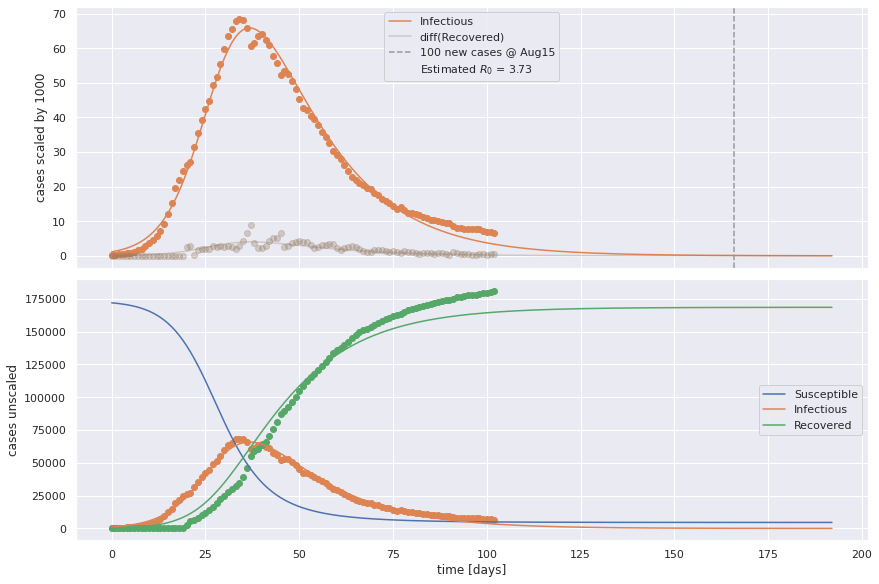

In [25]:
logit_days_to_predict = 90
xpredict = np.arange(len(xdata) + logit_days_to_predict)
sol = run_SIR(t=xpredict, R0=SIR_R0, **popt._asdict())

fig, ax = plt.subplots(2, 1, sharex=True, figsize=ut.MPL_FIG_SIZE_LARGE, constrained_layout=True)

ax[0].plot(xpredict, sol[:, 1], label='Infectious', color=FIG_COLOR_PALETTE[1])
ax[0].plot(xpredict[1:], np.diff(sol[:, 2]), label='diff(Recovered)', color=FIG_COLOR_PALETTE[5], alpha=0.3)
ax[0].scatter(xdata, ydata_rescaled[:, 0], color=FIG_COLOR_PALETTE[1])
ax[0].scatter(xdata, ydata_rescaled[:, 1], color=FIG_COLOR_PALETTE[5], alpha=0.3)
ax[0].set_ylabel('cases scaled by %d' % SIR_YDATA_SCALER)

IDX_OFFSET_TODAY = len(ydata)
idx100 = np.argmin(abs(sol[IDX_OFFSET_TODAY:, 1] - 100/SIR_YDATA_SCALER)) + IDX_OFFSET_TODAY
date100 = SIR_FIT_START_DATE + timedelta(days=int(idx100))
ax[0].axvline(idx100, color='0.6', ls='--', label='100 new cases @ %s' % date100.strftime(ut.MPL_FIG_TITLE_DATE_FORMAT))
ax[0].plot([], [], ' ', label='Estimated $R_0$ = %.2f' % R_0) # dirty way to add legend

for i, name in enumerate(['Susceptible', 'Infectious', 'Recovered']):
    ax[1].plot(xpredict, sol[:, i] * SIR_YDATA_SCALER, label=name)
ax[1].scatter(xdata, ydata_rescaled[:, 0] * SIR_YDATA_SCALER, color=FIG_COLOR_PALETTE[1])
ax[1].scatter(xdata, recovered[1:] , color=FIG_COLOR_PALETTE[2])
ax[1].legend(loc='best')
ax[1].set_xlabel('time [days]')
ax[1].set_ylabel('cases unscaled')

for i in [0, 1]:
    ax[i].legend().get_frame().set_alpha(0.9)

### Date of 100 new infections and reproduction number Germany based on SIR fit

[//]: # (
the complete table, only a subset is rendered below

| fit date | I = 100 date  |  R_0  | infec- tious days | S0 | I0 | SIR_R0 | beta | gamma | SIR_ YDATA_ SCALER | data | fit fct | lagrange | norm |
|:-----:| ------------| ----- | --------------- | -- | -- | ------ | ---- | ----- | ---------------- | --- | ------- | -------- | ---- |
| 2020-04-13 | 2020-05-06  | 1.175 | 1.048 | 505.9 | 0.1759 | 0.002 | 1.121 | 0.9542 | 1000 | JHU | op.curve_fit | - | L2 |
|   - " -    | 2020-05-11  | 1.3 | 1.88 | 197.8 | 0.2029 | 0 | 0.6914 | 0.532 | 1000 | BMP | op.curve_fit | - | L2 |
|   - " -    | 2020-05-07 | 1.383 | 2.222 | 136.5 | 0.2014 | 0 | 0.6223 | 0.4501 | 1000 | BMP | bfgs_curve_fit | 0.05 | L2 |
| 2020-04-15 | 2020-05-06 | 1.354 | 2.027 | 154.3 | 0.1914 | 0 | 0.668 | 0.4932 | 1000 | BMP | bfgs_curve_fit | 0.05 | L2 |
| 2020-04-16 | 2020-05-06 | 1.345 | 1.985 | 160.4 | 0.1937 | 0 | 0.678 | 0.5039 | 1000 | BMP | bfgs_curve_fit | 0.05 | L2 |
| 2020-04-17 | 2020-05-07 | 1.349 | 2.051 | 156.5 | 0.2082 | 0 | 0.6578 | 0.4875 | 1000 | BMP | bfgs_curve_fit | 0.05 | L2 |
| 2020-04-25 | 2020-05-21 | 1.171 | 1.388 | 439.2 | 0.3178 | 0 | 0.8434 | 0.7203 | 1000 | BMP | bfgs_curve_fit | 1.5 | L2 |
| 2020-04-26 | 2020-05-24 | 1.152 | 1.324 | 517.7 | 0.3429 | 0 | 0.8704 | 0.7553 | 1000 | BMP | bfgs_curve_fit | 1.5 | L2 |
| 2020-04-28 | 2020-05-25 | 1.148 | 1.3 | 537.9 | 0.3421 | 0 | 0.8833 | 0.7693 | 1000 | BMP | bfgs_curve_fit  | 1.5 | L2 |
| 2020-04-30 | 2020-05-26 | 1.139 | 1.262 | 590.1 | 0.3558 | 0 | 0.9026 | 0.7926 | 1000 | BMP | bfgs_curve_fit  | 1.5 | L2 |
| 2020-05-02 | 2020-05-29 | 1.128 | 1.223 | 656.7 | 0.3769 | 0 | 0.923 | 0.8179 | 1000 |  BMP | bfgs_curve_fit | 1.5 | L2 |
| 2020-05-02 | 2020-07-29 | 3.821 | 15.86 | 172 | 0.8357 | 0 | 0.2409 | 0.06307 | 1000 | BMP2 | bfgs_curve_fit | 15.85 | L1 |
|  - " -  | 2020-07-29 | 3.777 | 15.9 | 172 | 0.9955 | 0 | 0.2376 | 0.06291 | 1000 | BMP2 | bfgs_curve_fit | 1.585 | L1 
| 2020-05-03 | 2020-07-30 | 3.763 | 15.92 | 172 | 1.026 | 0 | 0.2364 | 0.06283 | 1000 | BMP2 | bfgs_curve_fit | 1.581 | L1 |
| 2020-05-09 | 2020-08-05 | 3.774 | 15.94 | 171.9 | 1.015 | 0 | 0.2368 | 0.06275 | 1000 | BMP2 | bfgs_curve_fit | 1.536 | L1 |
| 2020-05-16 | 2020-08-11 | 3.748 | 16.01 | 172 | 1.08 | 0 | 0.2342 | 0.06247 | 1000 | BMP2 | bfgs_curve_fit | 1.519 | L1 |
| 2020-05-17 | 2020-08-10 | 3.741 | 15.76 | 172.3 | 0.8883 | 0 | 0.2373 | 0.06343 | 1000 | BMP2 | bfgs_curve_fit | 15.18 | L1 |
| 2020-05-18 | 2020-08-10 | 3.747 | 15.8 | 172 | 0.8897 | 0 | 0.2371 | 0.06329 | 1000 | BMP2 | bfgs_curve_fit | 15.14 | L1 |
| 2020-05-23 | 2020-08-11 | 3.743 | 15.91 | 172 | 0.9535 | 0 | 0.2352 | 0.06284 | 1000 | BMP2 | bfgs_curve_fit | 15.05 | L1 |
| 2020-05-24 | 2020-08-12 | 3.738 | 16.04 | 172 | 1.035 | 0 | 0.233 | 0.06235 | 1000 | BMP2 | bfgs_curve_fit | 15.06 | L1 |
| 2020-05-30 | 2020-08-13 | 3.736 | 16.17 | 172 | 1.086 | 0 | 0.231 | 0.06184 | 1000 | BMP2 | bfgs_curve_fit | 15.01 | L1 |
| 2020-06-09 | 2020-08-14 | 3.732 | 16.28 | 172 | 1.116 | 0 | 0.2292 | 0.06142 | 1000 | BMP2 | bfgs_curve_fit | 15.01 | L1 |
| 2020-06-14 | 2020-08-15 | 3.726 | 16.35 | 172 | 1.147 | 0 | 0.2278 | 0.06115 | 1000 | BMP2 | bfgs_curve_fit | 15.01 | L1 |
)

| data | comment |
| ---- | ------- |
| BMP  | Berliner Morgen Post, used $I(t) = \text{new cases}_t$ |
| BMP2 | Berliner Morgen Post, $I(t) = I(t-1) + \text{new cases}_t - \text{new recovered}_t - \text{new death}_t $

| fit date | I = 100 date  |  R_0  | infec- tious days | S0 | I0 | SIR_R0 | beta | gamma | SIR_ YDATA_ SCALER | data | fit fct | lagrange | norm |
|:-----:| ------------| ----- | --------------- | -- | -- | ------ | ---- | ----- | ---------------- | --- | ------- | -------- | ---- |
| 2020-04-13 | 2020-05-07 | 1.383 | 2.222 | 136.5 | 0.2014 | 0 | 0.6223 | 0.4501 | 1000 | BMP | bfgs_curve_fit | 0.05 | L2 |
| 2020-04-25 | 2020-05-21 | 1.171 | 1.388 | 439.2 | 0.3178 | 0 | 0.8434 | 0.7203 | 1000 | BMP | bfgs_curve_fit | 1.5 | L2 |
| 2020-04-30 | 2020-05-26 | 1.139 | 1.262 | 590.1 | 0.3558 | 0 | 0.9026 | 0.7926 | 1000 | BMP | bfgs_curve_fit  | 1.5 | L2 |
| 2020-05-03 | 2020-07-30 | 3.763 | 15.92 | 172 | 1.026 | 0 | 0.2364 | 0.06283 | 1000 | BMP2 | bfgs_curve_fit | 1.581 | L1 |
| 2020-05-09 | 2020-08-05 | 3.774 | 15.94 | 171.9 | 1.015 | 0 | 0.2368 | 0.06275 | 1000 | BMP2 | bfgs_curve_fit | 1.536 | L1 |
| 2020-05-16 | 2020-08-11 | 3.748 | 16.01 | 172 | 1.08 | 0 | 0.2342 | 0.06247 | 1000 | BMP2 | bfgs_curve_fit | 1.519 | L1 |
| 2020-05-30 | 2020-08-13 | 3.736 | 16.17 | 172 | 1.086 | 0 | 0.231 | 0.06184 | 1000 | BMP2 | bfgs_curve_fit | 15.01 | L1 |
| 2020-06-14 | 2020-08-15 | 3.726 | 16.35 | 172 | 1.147 | 0 | 0.2278 | 0.06115 | 1000 | BMP2 | bfgs_curve_fit | 15.01 | L1 |

In [26]:
assert isinstance(popt, SIRFitParams)
params = [datetime.now(), date100, R_0, infectious_duration,
          popt.S0, popt.I0, SIR_R0, popt.beta, popt.gamma, SIR_YDATA_SCALER, 'BMP2', 'bfgs_curve_fit', lagrange, 'L1']
print(ut.markdown_table_fmt(params))

| 2020-06-14 | 2020-08-15 | 3.726 | 16.35 | 172 | 1.147 | 0 | 0.2278 | 0.06115 | 1000 | BMP2 | bfgs_curve_fit | 15.01 | L1 |


## Kalman filter to estimate $R_t$ also called $R_{\text{effective}}$

Mainly based on http://trackingr-env.eba-9muars8y.us-east-2.elasticbeanstalk.com/ and the corresponding code and paper. The paper, specifies the local-level model
$$gr(I_t) = \mu_t + \epsilon_t$$
$$\mu_t = \mu_{t-1} + \epsilon_t$$
Which is also documented als `Local-level` in the [statsmodels.tsa.statespace.structural.UnobservedComponents](https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.structural.UnobservedComponents.html#statsmodels.tsa.statespace.structural.UnobservedComponents).

[Growth-Rate](https://en.wikipedia.org/wiki/Population_growth):
$$\frac{\text{present} - \text{past}}{\text{past} \cdot (t_{\text{present}} - t_{\text{past}})}$$

### TODO:
- [ ] [Local Level Model - 2016Aarhus_Day1.pdf](https://econ.au.dk/fileadmin/user_upload/2016Aarhus_Day1.pdf)
- [ ] [Corona-Pandemie: Die Mathematik hinter den Reproduktionszahlen R | heise online](https://www.heise.de/newsticker/meldung/Corona-Pandemie-Die-Mathematik-hinter-den-Reproduktionszahlen-R-4712676.html)

In [27]:
%reset_selective -f ([xy][dipf][A-z]+[0-9]*|.*recovered.*|.*100)
%reset_selective -f (p0|pcov|popt|mask)

In [28]:
if False:
    KM_FIT_COUNTRY_KEY = 'TS_infectious_LR'
    KM_FIT_RECOVERED_KEY = 'TS_recovered_LR'   
    KM_FIT_START_DATE = datetime(2020, 3, 27)
else:
    KM_FIT_COUNTRY_KEY = 'Germany_infectious_BMP'
    KM_FIT_RECOVERED_KEY = 'Germany_recovered_BMP'
    KM_FIT_START_DATE = datetime(2020, 3, 2)

KM_INFECTIOUS_DURATION = timedelta(days=7)
KM_GAMMA = 1 / KM_INFECTIOUS_DURATION.days

mask = df.index >= KM_FIT_START_DATE

_infectious = df.loc[mask, KM_FIT_COUNTRY_KEY].values.astype('f8')
growth_rate = (_infectious[1:] - _infectious[:-1]) / _infectious[:-1]

In [29]:
model = sm.tsa.UnobservedComponents(growth_rate, 'local level')
res = model.fit(maxiter=1000, disp=True)
R_fct = lambda x: 1 + 1 / KM_GAMMA * x
R = R_fct(res.smoothed_state.ravel()) # 1 + 1 / KM_GAMMA * res.smoothed_state.ravel()
R_error = (1 + 1 / KM_GAMMA * res.smoothed_state[0, 0] ** 0.5)
R_error, np.median(R)

(5.317964828294804, 0.8252482352663698)

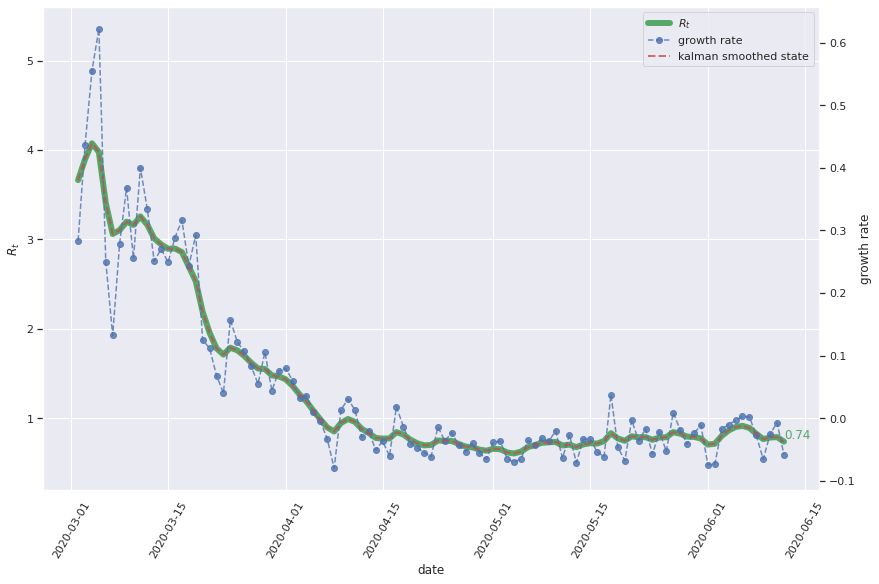

In [30]:
xdate = np.arange(KM_FIT_START_DATE,
                  KM_FIT_START_DATE + timedelta(days=len(R)),
                  dtype='datetime64[D]').astype('O')
ax = [None] * 2
fig, ax[0] = plt.subplots(1, 1, figsize=ut.MPL_FIG_SIZE_LARGE, constrained_layout=True)
lineR, = ax[0].plot(xdate, R, color='g', lw=6)
ax[1] = ax[0].twinx()
linegr, = ax[1].plot(xdate, growth_rate, 'o--', color='b', alpha=0.8)
linesm, = ax[1].plot(xdate, res.smoothed_state.ravel(), '--', color='r', lw=2, alpha=0.8)
labR, labgr, labsm = '$R_t$', 'growth rate', 'kalman smoothed state'
ax[0].set_ylabel(labR)
ax[0].set_xlabel('date')
ax[1].set_ylabel(labgr)
ax[1].grid(False);
ax[0].legend([lineR, linegr, linesm], [labR, labgr, labsm])
ax[0].legend([lineR, linegr, linesm], [labR, labgr, labsm])
#ax[0].set_ylim(-0.6, None);
ax[0].text(xdate[-1], R[-1] * 1.05, "%.2f" % R[-1], color='g');
fig.canvas.draw()
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=60);
ax[0].set_ylim(*[R_fct(v) for v in ax[1].get_ylim()]);